In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import gridspec
import seaborn as sns
import json
import torch

from bnn_priors import prior

from bnn_priors.exp_utils import load_samples

sns.set(context="paper", style="whitegrid", font_scale=1.5)
%matplotlib inline

## Define functions

In [2]:
# Adapted from https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python

import scipy.stats as st
import warnings
import tqdm
from sklearn.mixture import GaussianMixture

# Create models from data
def best_fit_distribution(data, bins=200):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    #DISTRIBUTIONS = [st.cauchy,st.gennorm,st.laplace,st.norm,st.t]
    DISTRIBUTIONS = [st.laplace,st.norm,st.t]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf
    
    sses = {}

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                sses[distribution.name] = sse

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            f"Failed to fit {distribution}"

    return (best_distribution.name, best_params, sses)


def make_pdf(dist, params, size=1000, start=None, end=None):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    if start is None:
        start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    if end is None:
        end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

In [3]:
def plot_weightdist(weights, title=None, num_bins=50):
    nrows = (len(weights)+1)//2
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(8,3*nrows))
    vmin = min(*map(np.min, weights_reshaped.values()))
    vmax = max(*map(np.max, weights_reshaped.values()))
    xlim = (vmin, vmax)
    for (name, weight), ax in zip(weights.items(), axes.ravel()):
        sns.distplot(weight.flatten(), ax=ax, bins=num_bins, kde=False, norm_hist=True)
        ax.set_xlabel(name)
        gauss_pdf = make_pdf(stats.norm, stats.norm.fit(weight), start=xlim[0], end=xlim[1])
        sns.lineplot(data=gauss_pdf, label="gaussian_fit", ax=ax)
        ax.legend(loc="upper right")
        
        ax.set_xlim(np.min(weight), np.max(weight))
    if title is not None:
        fig.suptitle(title)
        fig.tight_layout(rect=[0, 0, 1, 0.97])
    else:
        fig.tight_layout()
    return fig

In [4]:
def plot_covariance(weights_reshaped, rowvar, title=None, correlation=False):
    nrows = (len(weights_reshaped)+1)//2
    fig = plt.figure(figsize=(9,4*nrows))
    grid = gridspec.GridSpec(nrows=nrows,ncols=3,figure=fig,width_ratios=[20,20,1])
    axes = [plt.subplot(spec) for spec in grid]
    
    for (name, weight), ax in zip(weights_reshaped.items(), axes[::3] + axes[1::3]):
        cov = np.cov(weight, rowvar=rowvar)
        if correlation:
            cov *= (np.diag(cov) * np.diag(cov)[:, None])**-.5
        sns.heatmap(cov, cmap="Blues", ax=ax, vmin=np.min(cov), vmax=np.max(cov),
                    cbar=(name=="empirical"), cbar_ax=axes[2])
        ax.set_xlabel(name)
    if title is not None:
        fig.suptitle(title)
        fig.tight_layout(rect=[0, 0, 1, 0.97])
    else:
        fig.tight_layout()
    return fig

In [5]:
def plot_covar_offdiagonals(weights_reshaped, rowvar, title=None, num_bins=50):
    fig, axes = plt.subplots(ncols=2, figsize=(8,3))
    vmin = np.min([np.cov(weight, rowvar=rowvar) for weight in weights_reshaped.values()])
    xlim = (vmin,-vmin)
    for (name, weight), ax in zip(weights_reshaped.items(), axes):
        covar = np.cov(weight, rowvar=rowvar)
        offdiagonals = covar[np.where(~np.eye(covar.shape[0],dtype=bool))]
        sns.histplot(offdiagonals, ax=ax, bins=num_bins, kde=False, norm_hist=True)
        ax.set_xlabel(name)
        ax.set_xlim(xlim)
        gauss_pdf = make_pdf(stats.norm, stats.norm.fit(offdiagonals), start=xlim[0], end=xlim[1])
        sns.lineplot(data=gauss_pdf, label="gaussian_fit", ax=ax)
        ax.legend(loc="upper right")
    if title is not None:
        fig.suptitle(title)
        fig.tight_layout(rect=[0, 0, 1, 0.97])
    else:
        fig.tight_layout()
    return fig

In [6]:
def plot_singular_values(weights_reshaped, title=None, num_bins=10):
    fig, axes = plt.subplots(ncols=2, figsize=(8,3))
    for (name, weight), ax in zip(weights_reshaped.items(), axes):
        _, singvals, _ = np.linalg.svd(weight)
        sns.distplot(singvals, ax=ax, bins=num_bins, kde=False, norm_hist=True)
        ax.set_xlabel(name)
    if title is not None:
        fig.suptitle(title)
        fig.tight_layout(rect=[0, 0, 1, 0.97])
    else:
        fig.tight_layout()
    return fig

In [7]:
def generate_all_figures(state_dict, exp_name, cnn=True):
    if cnn:
        num_channels = 4
    else:
        num_channels = 2
    with PdfPages(f"../figures/{exp_name}_weight_distributions.pdf") as pdf:
        for param, weight_values in state_dict.items():
            if "weight_prior.p" in param and len(weight_values.shape) == num_channels:
                layer = param.split("weight_prior.p")[0]
                print(layer)

                weight = weight_values.numpy()
                weight_gaussian = np.random.normal(loc=weight.mean(), scale=weight.std(), size=weight.shape)
                weights = {"gaussian": weight_gaussian, "empirical": weight}
                weights_reshaped = {name : weight.reshape(weight.shape[0], -1) for name, weight in weights.items()}

                fig = plot_weightdist(weights, title=f"{layer}weight_distribution")
                pdf.savefig()
                plt.close(fig)
                fig = plot_covariance(weights_reshaped, False, title=f"{layer}covariance_inputs")
                pdf.savefig()
                plt.close(fig)
                fig = plot_covariance(weights_reshaped, True, title=f"{layer}covariance_outputs")
                pdf.savefig()
                plt.close(fig)
                fig = plot_covar_offdiagonals(weights_reshaped, False, title=f"{layer}covar_offdiag_inputs")
                pdf.savefig()
                plt.close(fig)
                fig = plot_covar_offdiagonals(weights_reshaped, True, title=f"{layer}covar_offdiag_outputs")
                pdf.savefig()
                plt.close(fig)
                fig = plot_singular_values(weights_reshaped, title=f"{layer}singular_values")
                pdf.savefig()
                plt.close(fig)
    print("done!")

## Load trained weights

In [9]:
from bnn_priors.notebook_utils import collect_runs

In [21]:
import pickle
import collections

def collect_weights():
    samples = collections.defaultdict( lambda: [], {})
    for i in range(10):
        try:
            s = load_samples(f"../logs/0_3_cifar10_sgd/{i}/samples.pt", idx=-1, keep_steps=False)
        except pickle.UnpicklingError:
            continue
        assert len(samples.keys()) == 0 or set(s.keys()) == set(samples.keys())
        for k in s.keys():
            samples[k].append(s[k])
    return {k: torch.stack(v, dim=0) for k, v in samples.items()}

In [22]:
samples = collect_weights()
samples

{'net.module.conv1.weight_prior.loc': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'net.module.conv1.weight_prior.p': tensor([[[[[-1.2823e-01, -1.0645e-01, -2.7594e-01],
            [-3.5081e-01,  6.1986e-02, -4.8562e-01],
            [-7.7150e-01, -7.2591e-01, -8.5602e-01]],
 
           [[-2.9594e-01, -1.3112e-01, -3.8527e-01],
            [-2.7009e-01,  6.1183e-01, -8.6411e-02],
            [-3.7935e-01,  1.9291e-01, -2.5951e-01]],
 
           [[ 1.7371e-01,  1.4770e-01, -2.4105e-01],
            [ 5.1259e-01,  1.5178e+00,  5.0935e-01],
            [ 7.4477e-01,  1.2728e+00,  3.2169e-01]]],
 
 
          [[[ 4.3327e-01,  1.6631e-01,  2.0795e-01],
            [-2.3308e-01,  1.8890e-01, -2.4319e-01],
            [ 8.7803e-02, -5.8147e-02, -1.5154e-01]],
 
           [[-3.2415e-01, -4.4583e-01, -1.0409e-01],
            [-4.5551e-01,  3.9725e-02,  1.9499e-01],
            [-1.3973e-01,  1.5266e-01, -8.6877e-02]],
 
           [[-5.1173e-01, -1.2997e-01,  2.8527e-01],
           

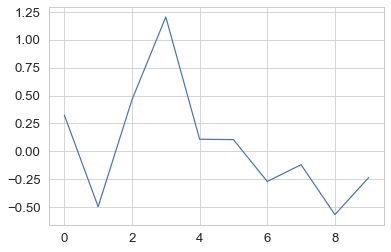

In [28]:
plt.plot(samples["net.module.linear.bias_prior.p"][-1, :])

# Fit each layer to a given degrees of freedom of MVT

In [30]:
import math

class MVTFitter(torch.nn.Module):
    def __init__(self, p, df):
        flat_p = p.view(-1, 9)
        cov = (flat_p.t() @ flat_p) / len(flat_p)
        
        super().__init__()
        self.dist = prior.MultivariateT(
            p.size(), torch.zeros(9), cov.cholesky().detach().to(torch.get_default_dtype()),
            df=torch.nn.Parameter(torch.tensor(df, requires_grad=True)),
            event_dim=2)
        
        self.dist.p.requires_grad_(False)
        self.dist.p[...] = p
        
    def closure(self):
        self.zero_grad()
        lp = -self.dist.log_prob()
        lp.backward()
        return lp
    
opt_dfs = {}

try_df_inits = torch.linspace(math.log(2.1), math.log(1000), 300).exp()

for key in conv_keys:
    max_lik = -np.inf
    
    mvt = MVTFitter(samples[key], 3.).cuda()
    for df_init in try_df_inits:
        with torch.no_grad():
            mvt.dist.df[...] = df_init
        #optim = torch.optim.LBFGS(mvt.parameters())
        #loss = optim.step(mvt.closure)
        
        lik = mvt.dist.log_prob().item()
        df = mvt.dist.df.item()
        if np.isnan(lik) or np.isnan(df):
            print("key", key, "saw a nan with lik", lik)
            
        if lik > max_lik:
            opt_dfs[key] = (lik, df)
            max_lik = lik
            
opt_dfs

{'net.module.conv1.weight_prior.p': (-2814.7861328125, 8.023161888122559),
 'net.module.layer1.0.conv1.weight_prior.p': (7207.517578125,
  4.693480968475342),
 'net.module.layer1.0.conv2.weight_prior.p': (6610.51220703125,
  6.136494159698486),
 'net.module.layer1.1.conv1.weight_prior.p': (7107.35888671875,
  6.528112888336182),
 'net.module.layer1.1.conv2.weight_prior.p': (7765.150390625,
  8.190327644348145),
 'net.module.layer2.0.conv1.weight_prior.p': (16089.3671875,
  10.708450317382812),
 'net.module.layer2.0.conv2.weight_prior.p': (36629.4765625,
  23.444801330566406),
 'net.module.layer2.1.conv1.weight_prior.p': (55604.015625,
  18.686710357666016),
 'net.module.layer2.1.conv2.weight_prior.p': (60973.78125, 28.225954055786133),
 'net.module.layer3.0.conv1.weight_prior.p': (100926.765625,
  34.69017791748047),
 'net.module.layer3.0.conv2.weight_prior.p': (236701.0, 51.32943344116211),
 'net.module.layer3.1.conv1.weight_prior.p': (298639.1875, 42.63481903076172),
 'net.module.lay

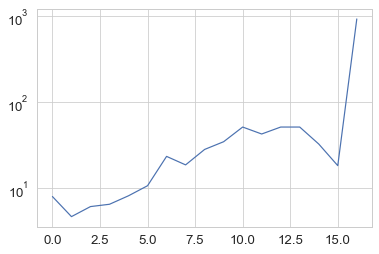

In [32]:
plt.plot([opt_dfs[k][1] for k in sorted(conv_keys)])
plt.yscale('log')

# Fit kernel model to a set of weights

In [120]:
import gpytorch
kern = gpytorch.kernels.MaternKernel(nu=3/2)

In [127]:
class ConvFitter(torch.nn.Module):
    def __init__(self, kern, weights):
        super().__init__()
        self.inputs = torch.from_numpy(np.mgrid[:3, :3].reshape(2, -1).T.astype(np.float32))
        self.kern = kern
        #self.raw_std = torch.nn.Parameter(torch.randn(9))
        #self.raw_std_constraint = gpytorch.constraints.Positive()
        
        self.register_buffer("weights", torch.from_numpy(weights).to(self.inputs, copy=True))
        
        cov = self.weights.t() @ self.weights / len(self.weights)
        std = cov.diag()**.5
        self.weights /= std
        
        self.register_buffer("std", std)
        self.register_buffer("cov", cov)
                        
    def forward(self):
        #std = self.raw_std_constraint.transform(self.raw_std)
        #std = self.std
        #L = std.unsqueeze(-1) * self.kern(self.inputs).cholesky().evaluate()
        dist = gpytorch.distributions.MultivariateNormal(
            torch.zeros(9), self.kern(self.inputs))
        return dist
    
    def closure(self):
        self.zero_grad()
        dist = self()
        loss = -dist.log_prob(self.weights).sum(0)
        loss.backward()
        return loss

In [ ]:
opt_states = {}

for key in list(weights_reshaped.keys()):
    max_lik = -np.inf
    for name, kern in [("matern_12",gpytorch.kernels.MaternKernel(nu=1/2)),
                       ("matern_32",gpytorch.kernels.MaternKernel(nu=3/2)),
                       ("matern_52",gpytorch.kernels.MaternKernel(nu=5/2)),
                       ("rbf", gpytorch.kernels.RBFKernel())]:
        cf = ConvFitter(kern, weights_reshaped[key])
        optim = torch.optim.LBFGS(cf.parameters())
        for _ in range(10):
            loss = optim.step(cf.closure)
        ls = cf.kern.lengthscale.item()
        lik = -loss.item()
        
        if lik > max_lik:
            max_ls = ls
            max_lik = lik
            max_name = name
            max_sd = cf.state_dict()
            del max_sd["weights"]
    opt_states[key] = (max_name, max_sd)
    print(f"For {key}, {max_name} with ls={max_ls}")

For gaussian, matern_12 with ls=0.0464433878660202
For module.conv1.weight, matern_32 with ls=1.0331251621246338
For module.layer1.0.conv1.weight, matern_32 with ls=0.9995145797729492
For module.layer1.0.conv2.weight, matern_32 with ls=1.071300983428955
For module.layer1.1.conv1.weight, matern_12 with ls=1.0023125410079956
For module.layer1.1.conv2.weight, rbf with ls=0.639470100402832
For module.layer2.0.conv1.weight, matern_32 with ls=1.592911958694458
For module.layer2.0.conv2.weight, rbf with ls=0.8009092211723328
For module.layer2.1.conv1.weight, rbf with ls=0.7830047607421875
For module.layer2.1.conv2.weight, rbf with ls=0.882695734500885
For module.layer3.0.conv1.weight, matern_32 with ls=1.2312480211257935
For module.layer3.0.conv2.weight, rbf with ls=0.7117388844490051
For module.layer3.1.conv1.weight, rbf with ls=0.7902165055274963
For module.layer3.1.conv2.weight, rbf with ls=0.8897801637649536
For module.layer4.0.conv1.weight, matern_32 with ls=1.0552213191986084


In [254]:
# Empirically the variance of the 10 outputs is pretty much the same
opt_states["module.linear.weight"] = (None, {'var': np.var(samples["module.linear.weight"][-1])})

for i in [2, 3, 4]:
    opt_states[f'module.layer{i}.0.shortcut.0.weight'] = (None, {'var': np.var(samples[f'module.layer{i}.0.shortcut.0.weight'][-1])})

In [258]:
#pd.to_pickle(opt_states, "opt_states.pkl.gz")

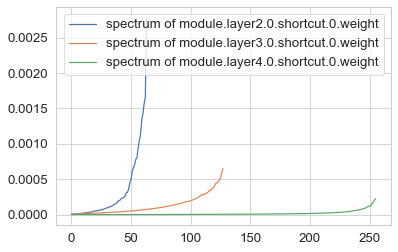

In [247]:
for i in [2, 3, 4]:
    plt.plot(np.linalg.eigvalsh(np.cov(samples[f"module.layer{i}.0.shortcut.0.weight"][-1, :, :, 0, 0], rowvar=False)),
         label=f"spectrum of module.layer{i}.0.shortcut.0.weight")
plt.legend()

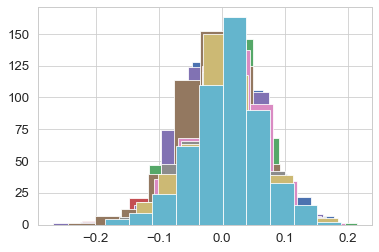

In [226]:
for i in range(10):
    plt.hist(samples["module.linear.weight"][-1, i])

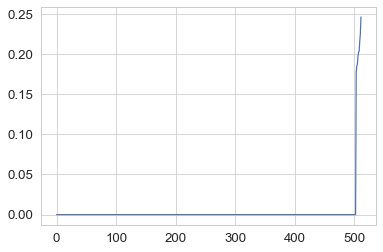

In [220]:
plt.plot(vals)

## Analyse point-wise distribution

In [20]:
weights_all["weights_all"].min(), weights_all["weights_all"].max()

(-0.29718557, 0.26971814)

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


KeyboardInterrupt: 

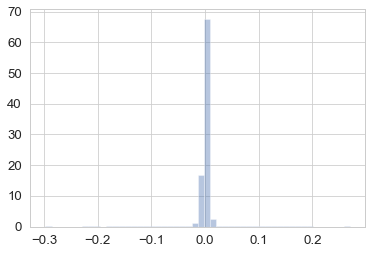

In [21]:
sns.distplot(weights_all["weights_all"])

In [ ]:
plot_weightdist(weights_reshaped, num_bins=50);

In [23]:
torch.distributions.StudentT(df=3, loc=0., scale=1.).sample([3])

tensor([1.7922, 0.1265, 0.2739])

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


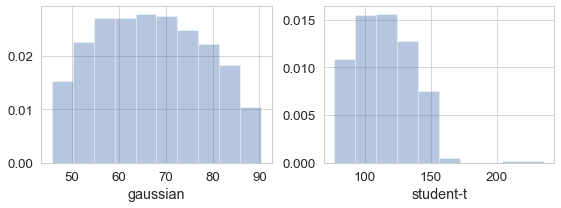

In [24]:
plot_singular_values({
    "gaussian": torch.randn(512, 512*9).numpy(),
    "student-t": torch.distributions.StudentT(df=3, loc=0., scale=1.).sample([512, 512*9]).numpy()});

## Analyse weight correlations

In [30]:
import gpytorch

In [38]:
gpytorch.kernels.MaternKernel(nu=3/2, )

Help on class MaternKernel in module gpytorch.kernels.matern_kernel:

class MaternKernel(gpytorch.kernels.kernel.Kernel)
 |  MaternKernel(nu=2.5, **kwargs)
 |  
 |  Computes a covariance matrix based on the Matern kernel
 |  between inputs :math:`\mathbf{x_1}` and :math:`\mathbf{x_2}`:
 |  
 |  .. math::
 |  
 |     \begin{equation*}
 |        k_{\text{Matern}}(\mathbf{x_1}, \mathbf{x_2}) = \frac{2^{1 - \nu}}{\Gamma(\nu)}
 |        \left( \sqrt{2 \nu} d \right) K_\nu \left( \sqrt{2 \nu} d \right)
 |     \end{equation*}
 |  
 |  where
 |  
 |  * :math:`d = (\mathbf{x_1} - \mathbf{x_2})^\top \Theta^{-1} (\mathbf{x_1} - \mathbf{x_2})`
 |    is the distance between
 |    :math:`x_1` and :math:`x_2` scaled by the :attr:`lengthscale` parameter :math:`\Theta`.
 |  * :math:`\nu` is a smoothness parameter (takes values 1/2, 3/2, or 5/2). Smaller values are less smooth.
 |  * :math:`K_\nu` is a modified Bessel function.
 |  
 |  There are a few options for the lengthscale parameter :math:`\Theta

In [29]:
weights_reshaped['module.layer2.0.conv1.weight'].shape

(262144, 9)

In [75]:
the_cov = np.cov(weights_reshaped['module.layer3.1.conv2.weight'], rowvar=False)

In [76]:
kern = gpytorch.kernels.MaternKernel(nu=3/2)
kern.lengthscale = 1.4

In [77]:
the_corr=  the_cov / np.diag(the_cov)[:, None]**.5 / np.diag(the_cov)[None, :]**.5

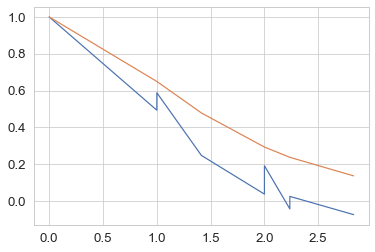

In [78]:
origin_y = origin_x = 0.
vals = []
for y in range(3):
    for x in range(3):
        dist = ((y - origin_y)**2 + (x - origin_x)**2)**.5
        
        kern_val = kern(torch.tensor([origin_x, origin_y]).unsqueeze(0), torch.tensor([x, y]).unsqueeze(0)).evaluate().item()
        
        vals.append((dist, the_corr[0, x + y*3], kern_val))
        
x, y_empirical, y_kernel = map(np.array, zip(*sorted(vals)))
plt.plot(x, y_empirical)
plt.plot(x, y_kernel)

In [80]:
weights = torch.from_numpy(weights_reshaped['module.layer3.1.conv2.weight'])
mean = weights.mean(0)

X = torch.arange(3).expand((3, 3))
positions = torch.stack([X, X.t()], dim=-1).reshape((3*3, 2)).to(torch.float32)


torch.Size([65536, 9])

In [93]:
positions

tensor([[0., 0.],
        [1., 0.],
        [2., 0.],
        [0., 1.],
        [1., 1.],
        [2., 1.],
        [0., 2.],
        [1., 2.],
        [2., 2.]])

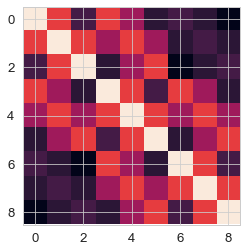

In [95]:
plt.imshow(kern(positions).evaluate().detach().numpy())

In [96]:
gpytorch.distributions.MultivariateNormal(, kern(positions)).covariance_matrix

AttributeError: 'dict' object has no attribute 'mean'

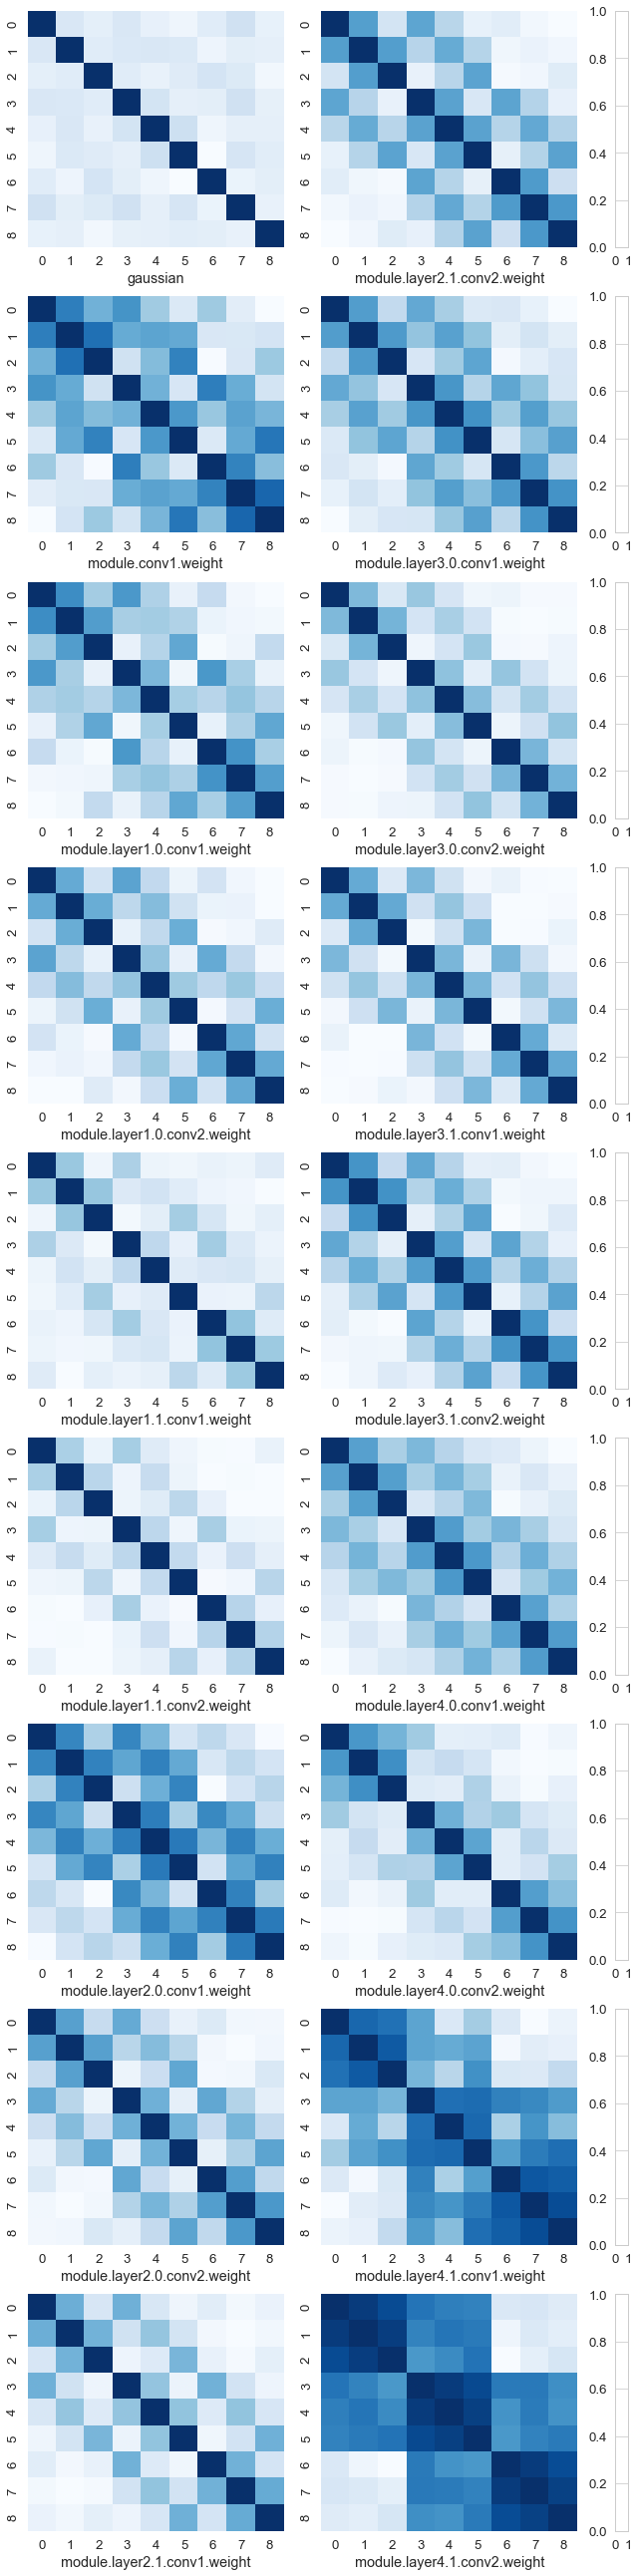

In [25]:
plot_covariance(weights_reshaped, False, correlation=True);

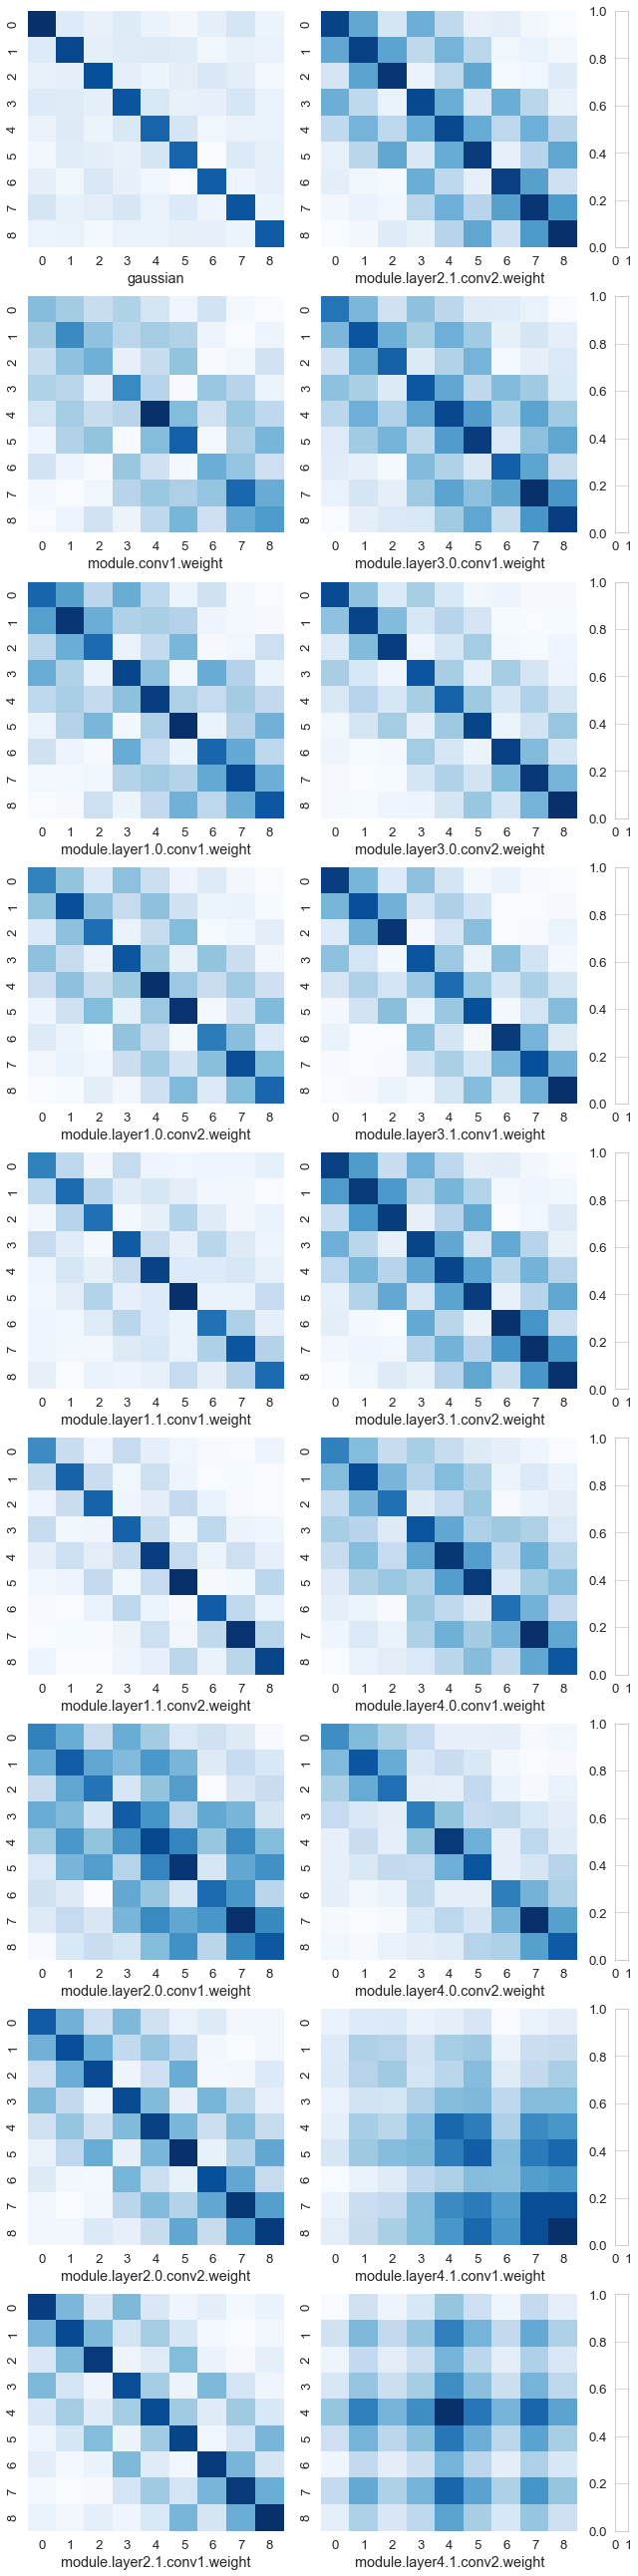

In [26]:
plot_covariance(weights_reshaped, False);

MemoryError: Unable to allocate 32.0 GiB for an array with shape (65536, 65536) and data type float64

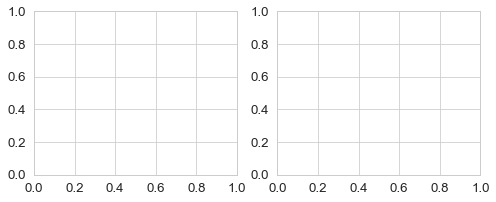

In [27]:
plot_covar_offdiagonals(weights_reshaped, True);

In [ ]:
plot_covar_offdiagonals(weights_reshaped, False);

## Analyse singular values

In [ ]:
plot_singular_values(weights_reshaped);

## Run analyses for all layers

In [ ]:
exp_name = "200918_mnist_cnn"

In [ ]:
for config_file in glob(f"../results/{exp_name}/*/config.json"):
    with open(config_file) as infile:
        config = pd.Series(json.load(infile))
    with open(config_file[:-11] + "run.json") as infile:
        result = pd.Series(json.load(infile)["result"], dtype=np.float32)
    run_data = pd.concat([config, result])
    if run_data["weight_prior"] == "improper" and run_data["temperature"] == 0.:
        print(run_data["weight_prior"], run_data["temperature"], run_data["weight_scale"], config_file)

In [ ]:
samples_file = f"../results/{exp_name}/20/samples.pt"

In [ ]:
samples = load_samples(samples_file)

In [ ]:
last_sample = {param: weights[-1] for param, weights in samples.items()}  # take the last sample of the chain

In [ ]:
generate_all_figures(last_sample, exp_name, cnn=True)

In [ ]:
from bnn_priors.exp_utils import get_model

model = get_model(x_train=None, y_train=None, model="resnet18", width=None, depth=None,
                  weight_prior="improper", weight_loc=0., weight_scale=1.,
                  bias_prior="improper", bias_loc=0., bias_scale=1.,
                  batchnorm=True, weight_prior_params={}, bias_prior_params={})

In [ ]:
model

In [ ]:
from bnn_priors.models.preact_resnet import PreActResNet18
net = PreActResNet18()

In [ ]:
net

In [ ]:
[name for name, _ in model.named_parameters() if ("weight_prior.p" in name or "bias_prior.p" in name)]

In [13]:
import pandas as pd
opt_mvt = pd.read_pickle("../bnn_priors/models/cifar10_opt_mvt.pkl.gz")
opt_mvt


{'net.module.conv1.weight_prior.p': (-2142.6464315337007,
  {'scale_tril': tensor([[ 4.4326e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
             0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
           [ 3.4001e-01,  4.7428e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
             0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
           [ 1.9810e-01,  2.6140e-01,  3.9021e-01,  0.0000e+00,  0.0000e+00,
             0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
           [ 2.4058e-01, -3.7766e-02, -3.9349e-02,  5.0243e-01,  0.0000e+00,
             0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
           [ 6.5821e-02,  2.2457e-01, -1.5073e-01,  1.9771e-01,  6.6687e-01,
             0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
           [-4.6380e-02,  1.8971e-01,  2.0167e-01, -2.7522e-02,  1.6678e-01,
             5.5194e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00],
           [-1.3466e-02, -2.9372e-02, -8.3373e-02,  1.9277e-01, -4.5777e-02,

In [9]:
#opt_mvt['df'] = opt_mvt['df'].apply(lambda x: x.item())

In [11]:
opt_mvt.sort_values("lik", ascending=False).remove_duplicates(("df", "event_dim"))

,df,event_dim,jitter,lik,loc,scale_tril
779,110.319037,2,"[[tensor(1.0000e-09, device='cuda:0', dtype=to...",2.702659e+06,"[tensor(-0.0022, device='cuda:0', dtype=torch....","[[tensor(0.0278, device='cuda:0', dtype=torch...."
775,110.319048,2,"[[tensor(1.0000e-09, device='cuda:0', dtype=to...",2.702659e+06,"[tensor(-0.0022, device='cuda:0', dtype=torch....","[[tensor(0.0278, device='cuda:0', dtype=torch...."
773,110.319049,2,"[[tensor(1.0000e-09, device='cuda:0', dtype=to...",2.702659e+06,"[tensor(-0.0022, device='cuda:0', dtype=torch....","[[tensor(0.0278, device='cuda:0', dtype=torch...."
777,110.319051,2,"[[tensor(1.0000e-09, device='cuda:0', dtype=to...",2.702659e+06,"[tensor(-0.0022, device='cuda:0', dtype=torch....","[[tensor(0.0278, device='cuda:0', dtype=torch...."
771,110.319055,2,"[[tensor(1.0000e-09, device='cuda:0', dtype=to...",2.702659e+06,"[tensor(-0.0022, device='cuda:0', dtype=torch....","[[tensor(0.0278, device='cuda:0', dtype=torch...."
...,...,...,...,...,...,...
751,-4938.535869,t,"[[tensor(1.0000e-09, device='cuda:0', dtype=to...",NaN,"[tensor(-12705656.8088, device='cuda:0', dtype...","[[tensor(13231019.5977, device='cuda:0', dtype..."
753,-4938.561110,t,"[[tensor(1.0000e-09, device='cuda:0', dtype=to...",NaN,"[tensor(-12705654.3692, device='cuda:0', dtype...","[[tensor(13231002.1130, device='cuda:0', dtype..."
755,-4938.533477,t,"[[tensor(1.0000e-09, device='cuda:0', dtype=to...",NaN,"[tensor(-12705657.0400, device='cuda:0', dtype...","[[tensor(13231021.2550, device='cuda:0', dtype..."
757,-4938.525391,t,"[[tensor(1.0000e-09, device='cuda:0', dtype=to...",NaN,"[tensor(-12705657.8215, device='cuda:0', dtype...","[[tensor(13231026.8564, device='cuda:0', dtype..."


In [22]:
import torch.nn.functional as F

for k in opt_mvt.keys():
    print(k, "\t\t", F.softplus(opt_mvt[k][1]['df']).item())


net.module.conv1.weight_prior.p 		 3.551517811239581
net.module.layer1.0.conv1.weight_prior.p 		 4.027361612574684
net.module.layer1.0.conv2.weight_prior.p 		 2.849470324089092
net.module.layer1.1.conv1.weight_prior.p 		 6.203926692729798
net.module.layer1.1.conv2.weight_prior.p 		 5.2891959883714605
net.module.layer2.0.conv1.weight_prior.p 		 16.927023631031958
net.module.layer2.0.conv2.weight_prior.p 		 55.28673461676345
net.module.layer2.0.shortcut.0.weight_prior.p 		 22.58557341242312
net.module.layer2.1.conv1.weight_prior.p 		 27.27332175242608
net.module.layer2.1.conv2.weight_prior.p 		 54.142690321373294
net.module.layer3.0.conv1.weight_prior.p 		 48.47739074547276
net.module.layer3.0.conv2.weight_prior.p 		 116.85582926051562
net.module.layer3.0.shortcut.0.weight_prior.p 		 1073.4695627983012
net.module.layer3.1.conv1.weight_prior.p 		 63.24963569289587
net.module.layer3.1.conv2.weight_prior.p 		 101.7267729872558
net.module.layer4.0.conv1.weight_prior.p 		 106.14998442701948
n

In [29]:
for k in opt_mvt.keys():
    print(k, opt_mvt[k][1]["scale_tril"].diag().log().sum())

net.module.conv1.weight_prior.p tensor(-6.8071, device='cuda:0', dtype=torch.float64)
net.module.layer1.0.conv1.weight_prior.p tensor(-14.9686, device='cuda:0', dtype=torch.float64)
net.module.layer1.0.conv2.weight_prior.p tensor(-14.4947, device='cuda:0', dtype=torch.float64)
net.module.layer1.1.conv1.weight_prior.p tensor(-15.2295, device='cuda:0', dtype=torch.float64)
net.module.layer1.1.conv2.weight_prior.p tensor(-15.4642, device='cuda:0', dtype=torch.float64)
net.module.layer2.0.conv1.weight_prior.p tensor(-15.7480, device='cuda:0', dtype=torch.float64)
net.module.layer2.0.conv2.weight_prior.p tensor(-16.2913, device='cuda:0', dtype=torch.float64)
net.module.layer2.0.shortcut.0.weight_prior.p tensor(-1.0716, device='cuda:0', dtype=torch.float64)
net.module.layer2.1.conv1.weight_prior.p tensor(-18.1564, device='cuda:0', dtype=torch.float64)
net.module.layer2.1.conv2.weight_prior.p tensor(-18.6680, device='cuda:0', dtype=torch.float64)
net.module.layer3.0.conv1.weight_prior.p tenso